# General Computer Interaction Language Alignment Critic

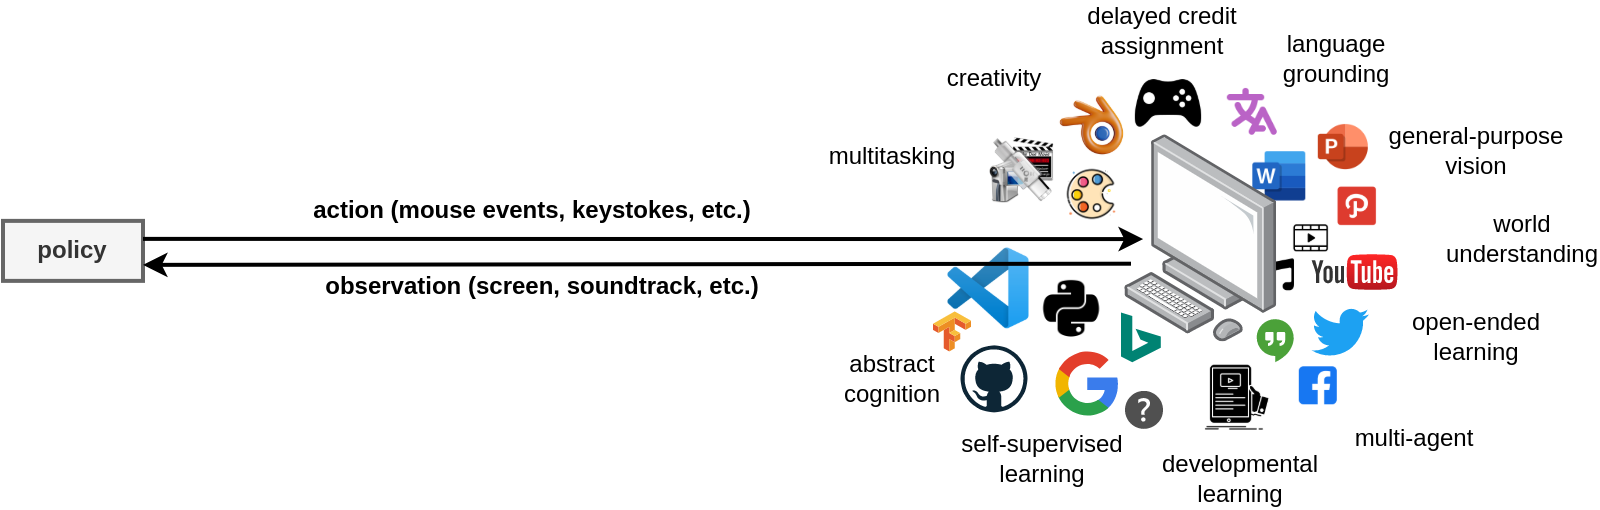 *The general-purpose computer reasonably covers the anthropocentric problem domain. Performance across many tasks in this open-world domain therefore gives a proxy of development towards `artificial general intelligence'.*

The general-purpose computer provides a simple interface to vast distributions of natural and synthetic complexity which reasonably proxy the anthropocentric problem domain. This inherently includes any dataset machine learning practitioners might use, billions hours of recorded audio and video, live social media feeds, uncountable scientific, engineering, business, and historical documents, as well as creative software, integrated development environments, simulators, engineering design tools, e-commerce platforms, business systems, and many more applications. Considered together with the Internet, the general-purpose computer is a ready-made multiagent, language-grounded, lifelong-learning environment-incubator for the development-evolution of progressively more capable, general, and autonomous artificial intelligence.

Targeting this open set of tasks is not simple due to their non-stationary distribution. This is further complicated by heterogeneous user interfaces and context-sensitive application of natural world metaphors such as location, navigation, and gesture. Then there is also the issue of estimating task progress, completion, and reward in spite of shifting and overlapping task boundaries. While still keeping complete autonomy in mind as an ultimate objective, these challenges advocate occasionally relaxing the autonomy constraint in exchange for natural language human guidance.

Natural language is already ubiquitous across graphical user interfaces. It allows transferring not only objectives but also cognitive models from human to agent thus helping align both the agent’s action and perception. Genuinely expressed natural language (not template statements) communicates deep relational hierarchies and dependencies. Most importantly, natural language is a high-bandwidth channel to rapidly infuse human-oracle information into the policy inference loop online. Rapid feedback accelerates the entire training loop iterating towards increasing capability, generality, and autonomy. Conversely, measuring a computer interaction agent’s sustained alignment with natural language instructions over long trajectories may provide a reasonable proxy of development towards the illusion of artificial general intelligence. (See figure above)

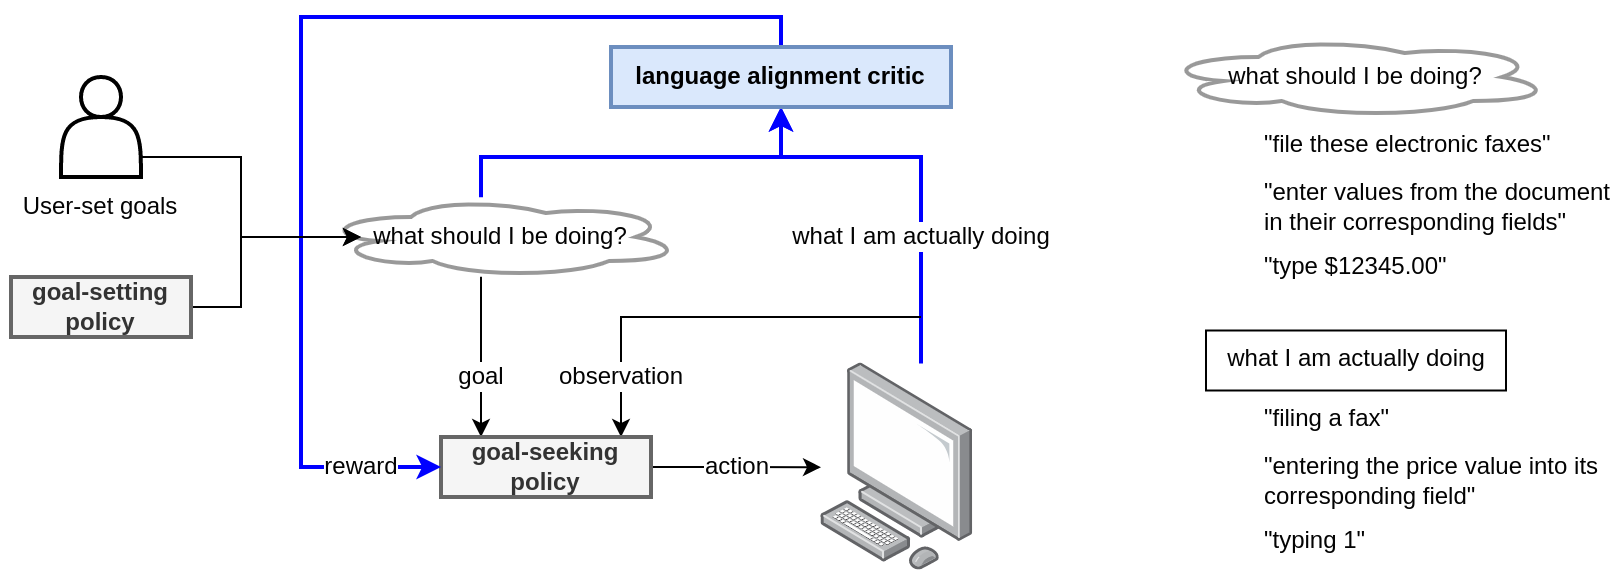 *Overall architecture of a general-purpose computer interaction agent. (a) The language alignment critic (this work, colored blue) provides feedback to an online continually learning policy. (b) Goals are encoded are natural language statements at various levels of granularity such as ``type \$12345.00'', ``enter values from the document in their corresponding fields'', and ``file these electronic faxes''.*

This work represents one step in that direction. I introduce a heterogeneous multitask, multimodal semi-supervised dataset of recorded computer interactions -- the User Experience (UE) -- and use it to train a multilevel action recognition system -- the General Computer Interaction Language Alignment Critic (GCI-LAC). Future work will use this critic network to not only passively measure action-language alignment but also guide active inference (keystrokes and mouse actions) in a real computer environment. (See figure above)

## Getting Started

In [51]:
!pip install -q hub
!pip install -q wikipedia
!python -m pip install -q git+https://github.com/pytube/pytube

In [6]:
import os
import time
import math
import random
import itertools
import functools

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import pytube
import hub
import tensorflow as tf

In [27]:
from pytube import YouTube
YouTube('https://youtu.be/2lAe1cqCOXo').streams.first().download()
yt = YouTube('http://youtube.com/watch?v=2lAe1cqCOXo')
yt.streams \
    .filter(progressive=True, file_extension='mp4') \
    .order_by('resolution') \
    .desc() \
    .first() \
    .download()

'/home/jacobfv123/YouTube Rewind 2019 For the Record  YouTubeRewind.mp4'

## The User Experience

Computer interaction demands an understanding of diverse modalities: mouse events, keystrokes, language, audio, image, and video. At this scale of complexity, it is not currently feasible to build a massive supervised mouse-keyboard-text-audio-image-video dataset. Even if such a dataset were available, it may be unproductive to build training loops that demand every modality to be present in an example. For example, in many computer applications, the audio modality is ignored. It would be memory and compute efficient to similarly skip audio-related processing in corresponding dataset examples. However, in other applications such as media players, audio is essential and other modalities such as the keyboard and mouse can instead be ignored. Regardless of the modalities involved, this work aims to estimate a similarity measure between their current state and a natural language goal description. To my knowledge, no single dataset combines information from all these diverse modalities. Therefore, in this section I introduce a heterogeneous multimodal semi/supervised conglomerate dataset of datasets: the User Experience (UE). 

The User Experience is currently composed of 3 datasets: COCO, spoken mnist, and a synthesized dataset of keystrokes and mouse events. Table \ref{table:ue} provides details on each of these classes. This collection will be expanded in the future. Some datasets in UE provide full descriptions at multiple levels of granularity, others pair brief or static inputs with single descriptions, and a large number merely provide raw data. Datasets are not batched by default. Each example is structured as a dictionary with the keys `mouse`, `keyboard`, `screen`, `audio`, `description`. Not all keys are present in every dataset example. The \verb|mouse| modality is encoded by a 6-dimensional 32-bit float-valued tensor `<x location, y location, movement down (-) / up (+), movement left (-) / right (+), left button down, right button down>`. The `keyboard` modality is encoded as a 256-dimensional Boolean-valued vector with control, alphanumeric, and symbolic characters following ASCII mapping. The `screen` modality is variable sized RGB tensor with 32-bit floating point values already normalized in $[0,1]$. The `audio` modality is encoded in a variable length 16kHz, 16bit normalized waveform with amplitude values in $[-1, 1]$. The `description` modality contains a concatenated string of natural language descriptions for the action, image, or audio that it is paired with. If there are no descriptions, this modality is dropped (i.e.: it always has a nonzero length). Sample rate varies between datasets. However all modalities except for `audio` share a common number of timesteps per individual dataset example. The audio modality, if present, will have significantly more entries on its time axis as a result of its 16kHz sampling rate.

### COCA Dataset

In [4]:
# tf dataset helper
# copied from https://www.tensorflow.org/tutorials/text/image_captioning#download_and_prepare_the_ms-coco_dataset

# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510582272/13510573713 [==============================] - 307s 0us/step


6000
<start> A cat is climbing up a book shelf <end>


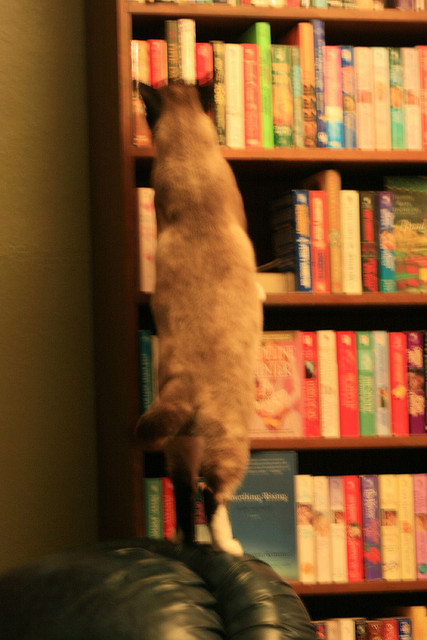

In [45]:
# further processing
# copied from https://www.tensorflow.org/tutorials/text/image_captioning#download_and_prepare_the_ms-coco_dataset

import json
import collections
from PIL import Image

with open(annotation_file, 'r') as f:
    annotations = json.load(f)
    
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:6000]
print(len(train_image_paths))

train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

print(train_captions[0])
Image.open(img_name_vector[0])

### Spoken Mnist

This dataset pairs the numbers 0 through 9 with spoken audio. Labels are integers numbered 0-9 and audio is normalized in $[-1,1]$.

In [40]:
spoken_mnist = hub.load("hub://activeloop/spoken_mnist")

Opening dataset in read-only mode as you don't have write permissions.
hub://activeloop/spoken_mnist loaded successfully.


In [46]:
spoken_mnist.labels[0].numpy(), spoken_mnist.audio[0].numpy()

(array([0], dtype=uint32),
 array([[-0.04544067],
        [-0.02935791],
        [-0.01849365],
        ...,
        [-0.05535889],
        [-0.03387451],
        [-0.00045776]]))

### Synthetic computer data set

This dataset is just a collection of synthetic data. It is currently not useful for data engineering, but still is useful for testing basic model errors.

In [52]:
import wikipedia

In [68]:
text = wikipedia.summary("language")
keystrokes = [ord(c) for c in text]
mouse = tf.random.normal(shape=(len(text), 2))
ds = # TODO

2021-12-08 05:46:40.605264: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-08 05:46:40.769202: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-08 05:46:40.770134: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-08 05:46:40.778924: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## General Computer Interaction Language Alignment Critic

As shown in the first figure, general-purpose computer interaction sits at the nexus of numerous problem domains involving mouse event and keystroke analysis, natural language processing, object detection, action sequence segmentation, audio/video understanding, and control. Drawing on existing contributions, this work combines pretrained models for most modalities separately and only trains a relatively small recurrent-state attention-based joint embedding network. The dot product between the joint embedding produced from computer modalities and the task semantic embedding is used to train a language alignment critic in CLIP-fashion. The figure below presents a visual anatomy of this architecture.

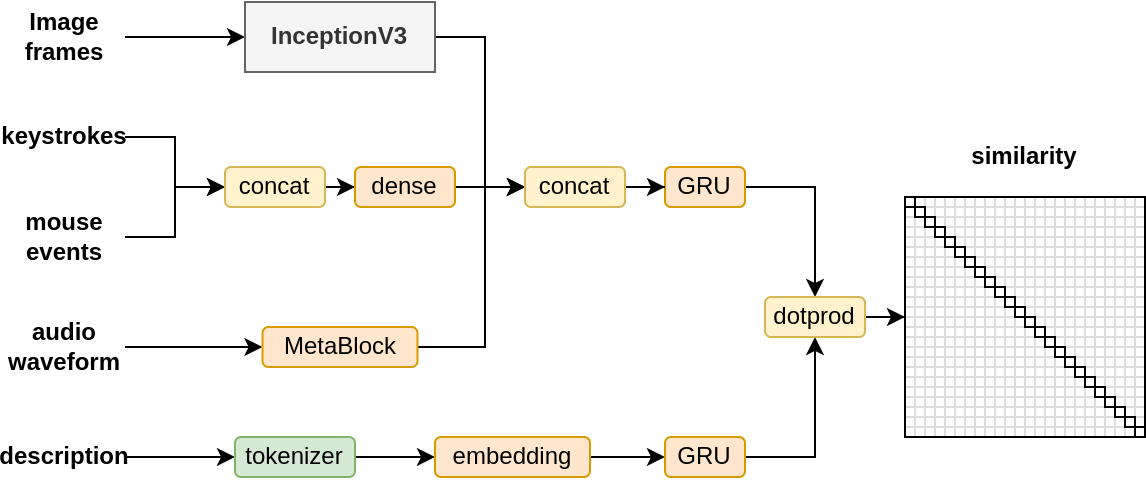 *The language alignment critic uses a diverse set of modalities to predict a nontrivial vector that aligns with a language description semantic vector. Architecture primarily follows heuristic design.*

## Experiment and Future Work 

Unfortunately, we did not have time to perform experiments on this architecture. Future work will finish the data loader and test a simple classifier architecture.

## References

- https://www.tensorflow.org/tutorials/text/image_captioning

- https://cocodataset.org/#home

- 